In [1]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "white"

db_con = psycopg2.connect(
    host="localhost",
    port="5432",
    database="hoard_test_retr",
    user="hoarder",
    password="password")


In [2]:
 cids = pd.read_sql_query("""SELECT cid_hash FROM cid_info;""", db_con) 

In [3]:
ping_rounds = pd.read_sql_query("""
select ping_round, count(ping_round) from ping_results group by ping_round order by ping_round ASC;""", db_con)

In [4]:
# Get the CID Publish times for the CIDs
pub_times = pd.read_sql_query("""
    select cid_hash, gen_time from cid_info order by cid_hash;
    """, db_con)

# Get total pub time 
mn = min(pub_times['gen_time'])
mx = max(pub_times['gen_time'])

pub_t = (mx - mn) / 60 # conver to mins
print(f'{pub_t} mins to publish the CIDs')

0.38333333333333336 mins to publish the CIDs


In [5]:
# get the median time of each fetch time
hours_dist = []
for idx, row in ping_rounds.iterrows():
    # get the fetch times
    fetch_round = pd.read_sql_query(f"""
        select cid_hash, fetch_time from fetch_results where ping_round={row['ping_round']} order by cid_hash;
        """, db_con)
    fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fetch_round['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))

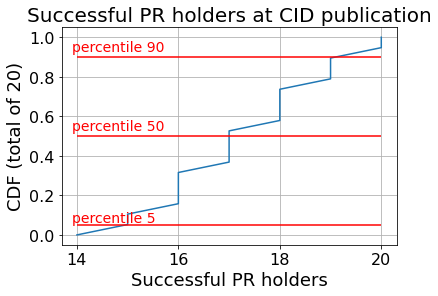

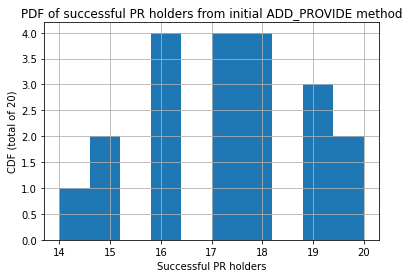

In [6]:
# Get the number of successfull ADD_PR 
pobj = pd.read_sql_query(f"""
select success_att from fetch_results where ping_round=0 order by success_att ASC""", db_con)

per_1 = {'smalest_value': 0.0, 'x': 0.0}

plt.plot(pobj["success_att"], np.linspace(0, 1, len(pobj)))
plt.title("Successful PR holders at CID publication", fontsize=20)
plt.xlabel("Successful PR holders", fontsize=18)
plt.ylabel(f"CDF (total of {len(cids)})", fontsize=18)
plt.grid()
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.55, 'percentile 50', ha='left', va='center', color='r', fontsize=14)
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.95, 'percentile 90', ha='left', va='center', color='r', fontsize=14)
plt.hlines(y=[0.05], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.0825, 'percentile 5', ha='left', va='center', color='r', fontsize=14)

plt.show()

plt.hist(pobj["success_att"], bins=10)
plt.title("PDF of successful PR holders from initial ADD_PROVIDE method")
plt.xlabel("Successful PR holders")
plt.ylabel(f"CDF (total of {len(cids)})")
plt.grid()
plt.show()


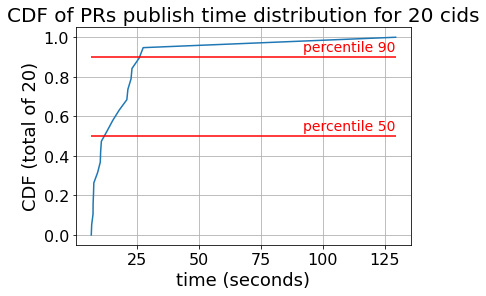

In [7]:
# TODO: Add Percentiles to the top of the graphics

# Get the time to the IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)
pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods

plt.plot(pobj["provide_time"],np.linspace(0, 1, len(pobj)))
plt.title(f'CDF of PRs publish time distribution for {len(pobj)} cids', fontsize=20)
plt.xlabel("time (seconds)", fontsize=18)
plt.ylabel(f"CDF (total of {len(pobj)})", fontsize=18)

plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.55, 'percentile 50', ha='right', va='center', color='r', fontsize=14)
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.95, 'percentile 90', ha='right', va='center', color='r', fontsize=14)

plt.grid()

#plt.hist(pobj['provide_time'], cdf_pt)

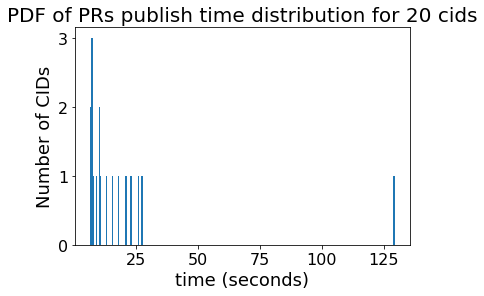

In [8]:
plt.hist(pobj['provide_time'], density=False, bins=256)
plt.title(f'PDF of PRs publish time distribution for {len(pobj)} cids', fontsize=20)
plt.xlabel("time (seconds)", fontsize=18)
plt.ylabel(f"Number of CIDs", fontsize=18)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)


541
   total_hops  count          %
0           2      1   0.184843
1           3     68  12.569316
2           4    223  41.219963
3           5    176  32.532348
4           6     67  12.384473
5           7      6   1.109057


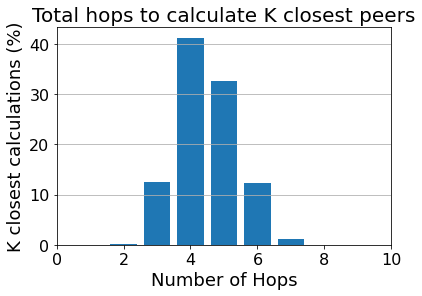

541
   hops_for_closest  count          %
0                 1      1   0.184843
1                 2     83  15.341959
2                 3    249  46.025878
3                 4    167  30.868762
4                 5     33   6.099815
5                 6      8   1.478743


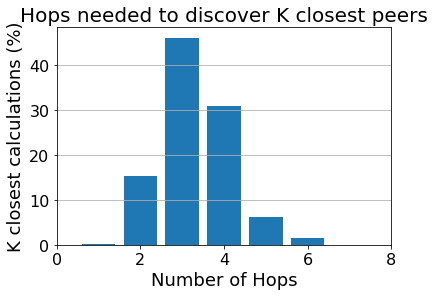

In [9]:
# Get the number of total hops that needed to be done to get the closest peers over the entire study

hops_obj = pd.read_sql_query("""
select total_hops, count(total_hops) from fetch_results group by total_hops order by total_hops ASC;
""", db_con)

# get total
tot_hops = hops_obj["count"].sum()
print(tot_hops)

hops_obj["%"] = (hops_obj["count"]/tot_hops)*100
print(hops_obj)

fig, ax = plt.subplots()
box_dict = ax.bar(hops_obj["total_hops"], hops_obj["%"])
ax.set_ylabel("K closest calculations (%)", fontsize=18)
ax.set_xlabel("Number of Hops", fontsize=18)
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
ax.set_xlim(0, 10)
plt.title(f'Total hops to calculate K closest peers', fontsize=20)
plt.grid(axis='y')
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()


# Get the number of hops that needed to know all the closest peers over the entire study

hops_obj = pd.read_sql_query("""
select hops_for_closest, count(hops_for_closest) from fetch_results group by hops_for_closest order by hops_for_closest ASC;
""", db_con)

# get total
tot_hops = hops_obj["count"].sum()
print(tot_hops)

hops_obj["%"] = (hops_obj["count"]/tot_hops)*100
print(hops_obj)

fig, ax = plt.subplots()
box_dict = ax.bar(hops_obj["hops_for_closest"], hops_obj["%"])
plt.title(f'Hops needed to discover K closest peers', fontsize=20)
ax.set_ylabel("K closest calculations (%)", fontsize=18)
ax.set_xlabel("Number of Hops", fontsize=18)
ax.set_ylim(bottom=0)
ax.set_xlim(0, 8)

plt.grid(axis='y')
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()


0.05     6.60525
0.25     7.43850
0.50    11.68800
0.75    21.55300
0.90    25.95050
Name: provide_time, dtype: float64


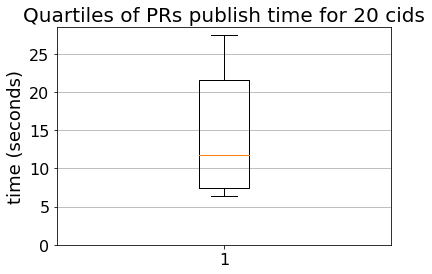

In [10]:
# Quartiles of time to execute IPFS DHT Provide method

fig, ax = plt.subplots()
box_dict = ax.boxplot(pobj["provide_time"], showfliers=False)
ax.set_ylabel("time (seconds)", fontsize=18)
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
plt.title(f'Quartiles of PRs publish time for {len(pobj)} cids', fontsize=20)
plt.grid(axis='y')

plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

print(pobj['provide_time'].quantile([0.05,0.25,0.5,0.75, 0.90]))

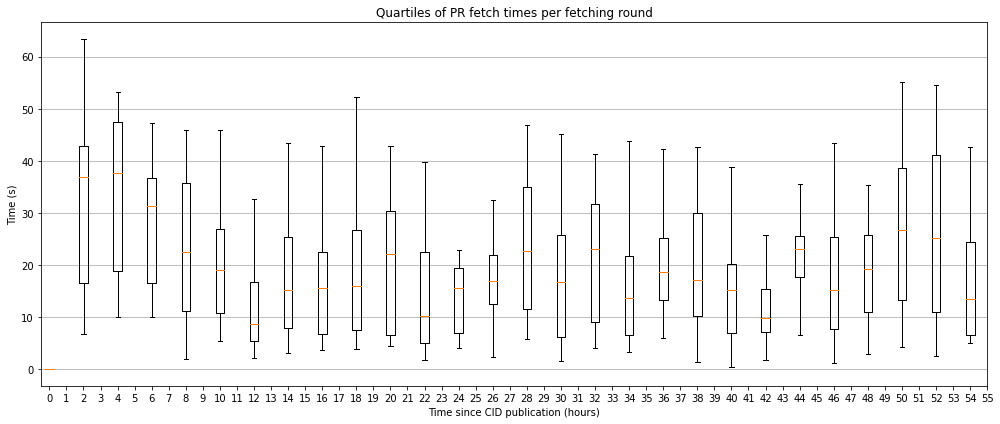

In [11]:
# Get the time to ping PR Holders

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

fetch_time_dist = []
hours_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    fpd_round_ftime = pd.read_sql_query(f'select cid_hash, fetch_time, fetch_duration from fetch_results where ping_round={row["ping_round"]} order by cid_hash', db_con) 
    fetch_time_dist.append(fpd_round_ftime['fetch_duration'] / 1000 ) # convert to secs 
    
    fpd_round_ftime['time of pub'] = (fpd_round_ftime['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fpd_round_ftime['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))
    
fig, ax = plt.subplots()
ax.figure.set_size_inches(14, 6)
ax.boxplot(fetch_time_dist, positions=hours_dist, showfliers=False) 
ax.set_xlabel("Time since CID publication (hours)")

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))
ax.set_ylabel("Time (s)")

plt.title("Quartiles of PR fetch times per fetching round")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



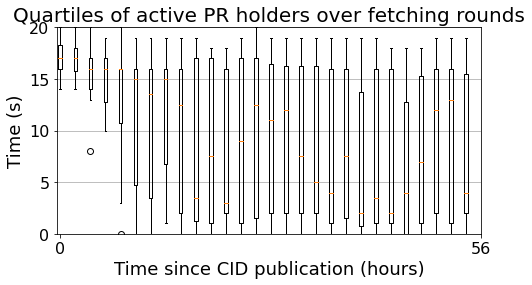

In [12]:

# Get active PR holders over fetch rounds (just for double check following distributions)

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

succ_att_dist = []
hours_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    p = pd.read_sql_query(f'select cid_hash, fetch_time, success_att from fetch_results where ping_round={row["ping_round"]} order by cid_hash;', db_con) 
    succ_att_dist.append(p['success_att'])

    p['time of pub'] = (p['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = p['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))
    
fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(succ_att_dist, positions=hours_dist, showfliers=True) 
ax.set_xlabel("Time since CID publication (hours)", fontsize=18) # TODO: hardcoded to 30 mins
ax.set_ylabel("Active PR holders", fontsize=18)
ax.set_ylim(0, max(succ_att_dist[0]))

# set net xticks to int hours
ticks = np.linspace(0, np.round(hours_dist[-1])+2, 2)
ax.set_xticks(ticks, ticks.astype(int))
ax.set_ylabel("Time (s)")

plt.title(f"Quartiles of active PR holders over fetching rounds", fontsize=20)
plt.grid(axis='y')
plt.tight_layout()
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()


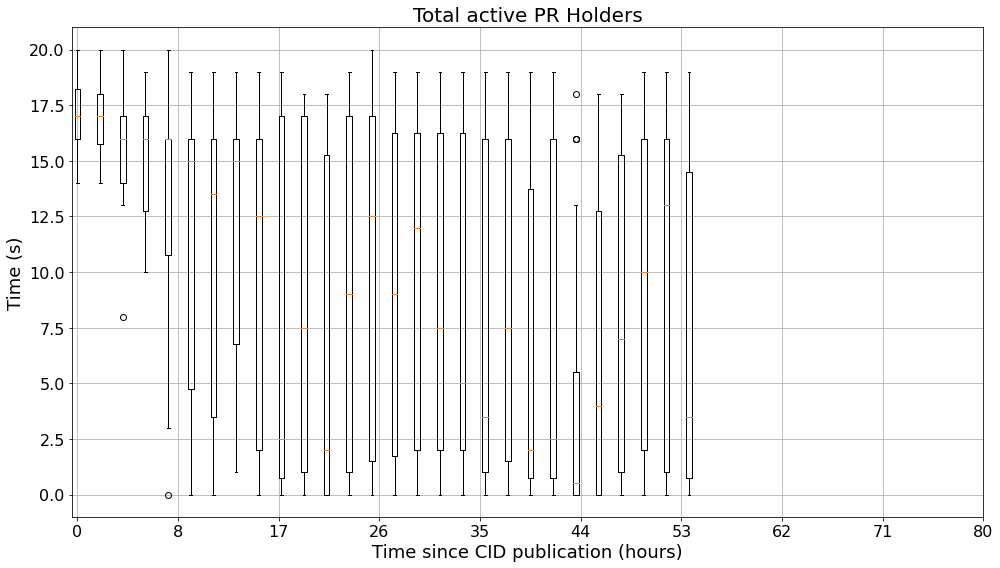

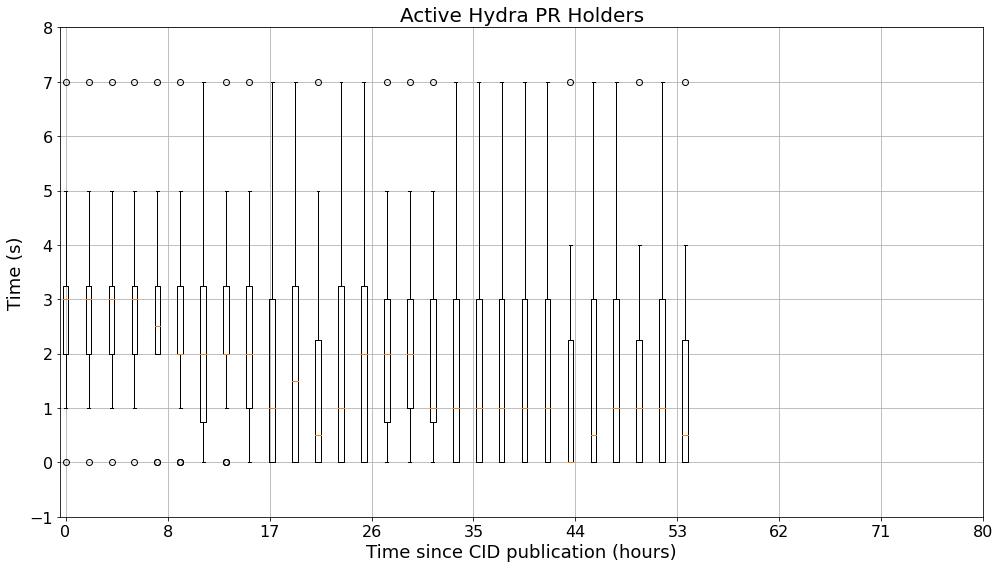

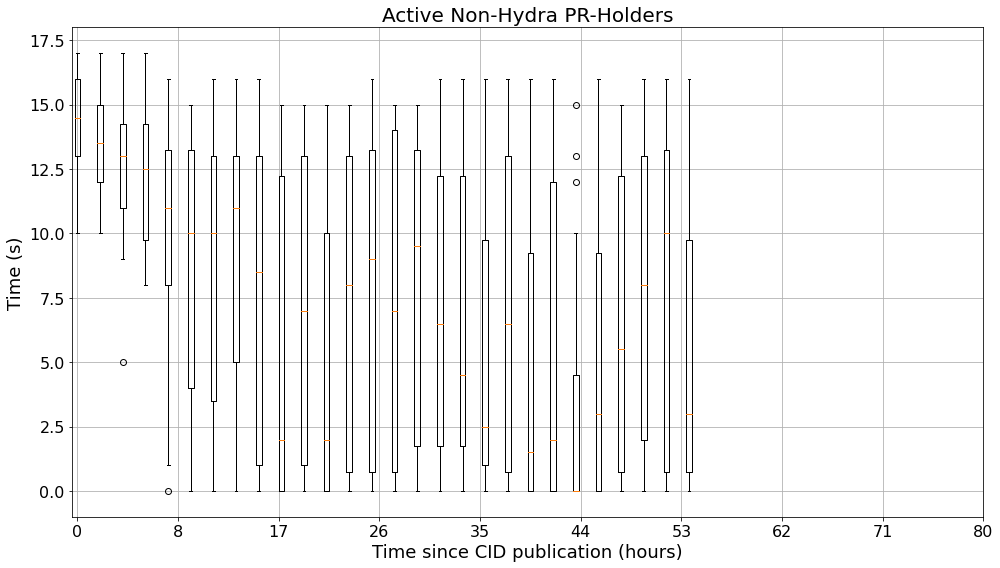

In [13]:
# Get active PR holders over fetch rounds hydra peers

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
]
title_set = [
    "Total active PR Holders", 
    "Active Hydra PR Holders", 
    "Active Non-Hydra PR-Holders"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        # Add 0 for those lines without active lines
        for i in range(len(cids) - len(active_p)):
            aux_act.append(0)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)
    
    # active hydras vs active no hydras
    fig, ax = plt.subplots(figsize=(14,8))
    ax.boxplot(active_tot, positions=hours_dist, showfliers=True) 
    ax.set_title(title_set[item], fontsize=20)

    # set net xticks to int hours
    ticks = np.linspace(0, 80, 10) # np.round(hours_dist[-1])+2
    ax.set_xticks(ticks, ticks.astype(int))
    #ticks = np.arange(np.round(hours_dist[-1])+2)
    #ax.set_xticks(ticks, ticks.astype(int))
    ax.set_xlabel("Time since CID publication (hours)", fontsize=18)
    ax.set_ylabel("Time (s)", fontsize=18)
    ax.set_ylim(-1, max(active_tot[0])+1)
    
    
    plt.tick_params(axis='x', which='major', labelsize=16)
    plt.tick_params(axis='y', which='major', labelsize=16)

    plt.grid()
    plt.tight_layout()
    plt.show()

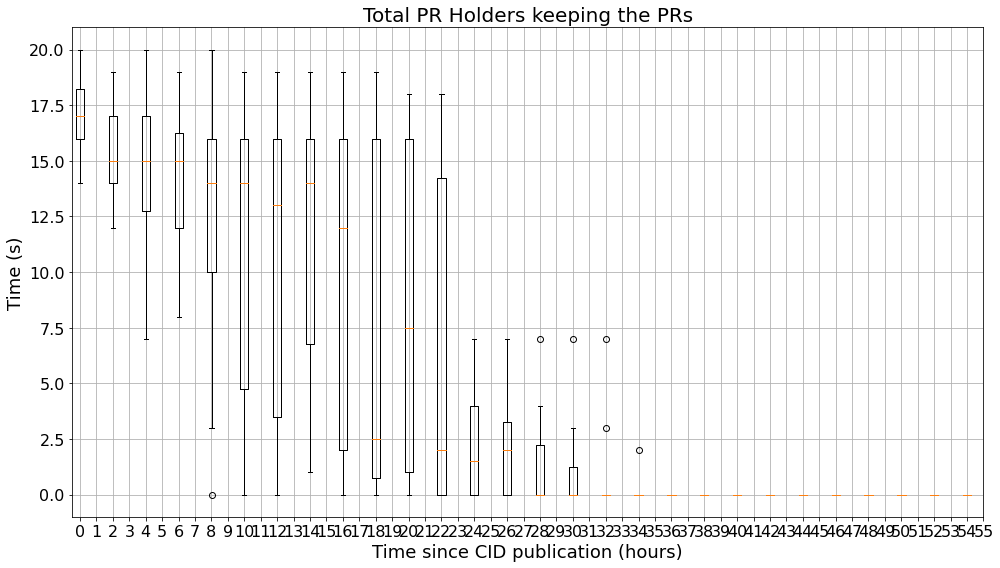

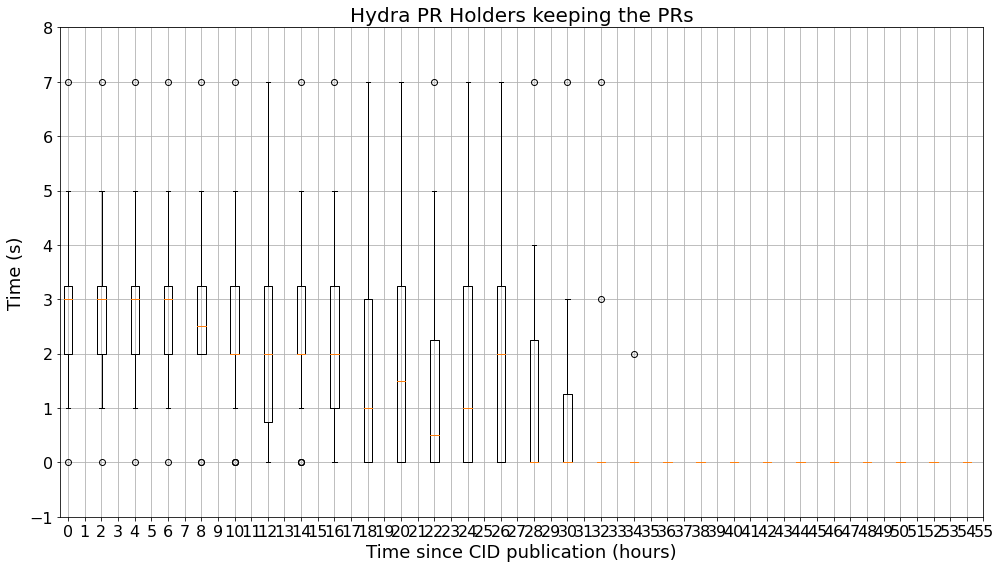

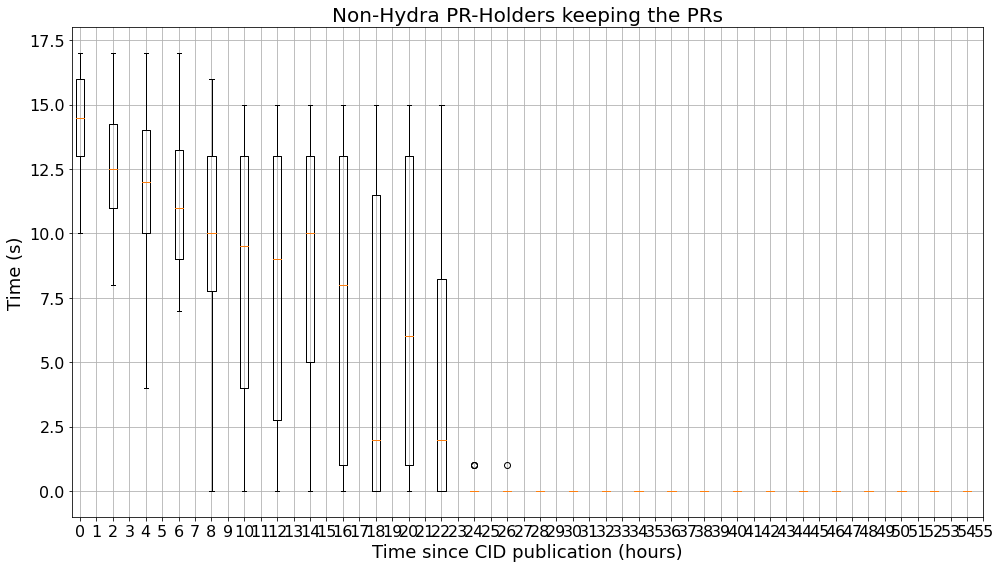

In [14]:
# Get PR holders keeping the PRs over fetch rounds

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
]

title_set = ["Total PR Holders keeping the PRs", "Hydra PR Holders keeping the PRs", "Non-Hydra PR-Holders keeping the PRs"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        # Add 0 for those lines without active lines
        for i in range(len(cids) - len(active_p)):
            aux_act.append(0)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)
        

    # active hydras vs active no hydras
    fig, ax = plt.subplots(figsize=(14,8))
    ax.boxplot(active_tot, positions=hours_dist, showfliers=True) 
    ax.set_title(title_set[item], fontsize=20)

    # set net xticks to int hours
    ticks = np.arange(np.round(hours_dist[-1])+2)
    ax.set_xticks(ticks, ticks.astype(int))
    ax.set_xlabel("Time since CID publication (hours)", fontsize=18)
    ax.set_ylabel("Time (s)", fontsize=18)
    ax.set_ylim(-1, max(active_tot[0])+1)
    
    plt.tick_params(axis='x', which='major', labelsize=16)
    plt.tick_params(axis='y', which='major', labelsize=16)

    plt.grid()
    plt.tight_layout()
    plt.show()

          client  count  client percentage
0        go-ipfs    227              56.75
1  hydra-booster     60              15.00
2            ioi      2               0.50
3  NotIdentified     55              13.75
4         Others     48              12.00
5          storm      8               2.00


Text(0.5, 1.0, 'Client distribution of total PR Holders')

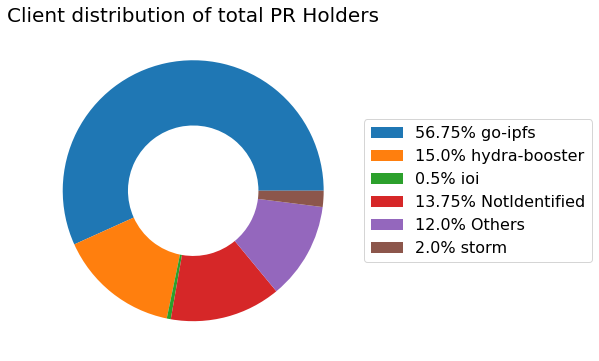

In [15]:
# Get client distribution on PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by client ASC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{round(row["client percentage"], 2)}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))#, startangle=-40)

ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 16})
ax.set_title("Client distribution of total PR Holders", fontsize=20)



          client  count  client_ratio
0        go-ipfs    227         11.35
1  hydra-booster     60          3.00
2  NotIdentified     55          2.75
3         Others     48          2.40
4          storm      8          0.40
5            ioi      2          0.10


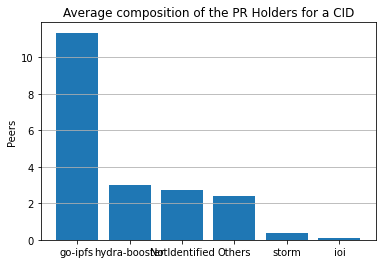

In [16]:
# Get number of Hyda boosters as PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client_ratio"] = (pobj["count"]) / len(cids)
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client_ratio"]}% {row["client"]}'
    labels.append(r)

plt.bar(pobj['client'], pobj['client_ratio'])
plt.title("Average composition of the PR Holders for a CID")
plt.ylabel("Peers")
plt.grid(axis='y')
    

Text(0.5, 1.0, 'Error distribution over fetch rounds')

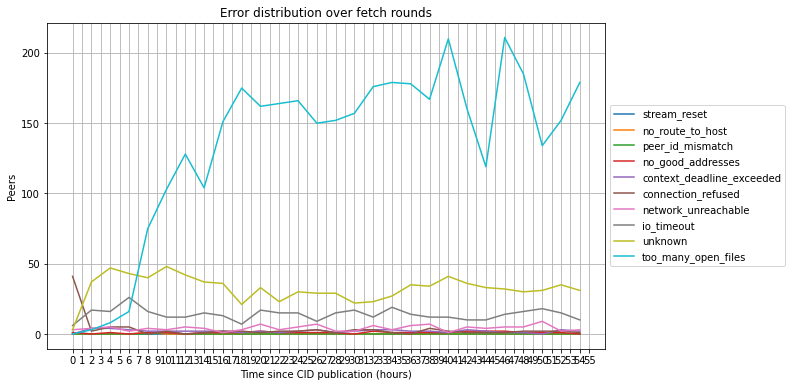

In [17]:
# Check the error getting connecting PR Holders

# get cids
cidobj = pd.read_sql_query('select id, cid_hash from cid_info', db_con)

# get list of errors from the entire pings
errorsobj = pd.read_sql_query('select conn_error, count(conn_error) from ping_results group by conn_error order by count(conn_error)', db_con)

pingsobj = pd.read_sql_query("select ping_round from ping_results group by ping_round order by ping_round ASC", db_con)

err_dist = {}
for i, r in errorsobj.iterrows():
    err_dist[r['conn_error']] = []
    
for i, r in pingsobj.iterrows():
    errorsobj = pd.read_sql_query(f'select conn_error, count(conn_error) from ping_results where ping_round={r["ping_round"]} group by conn_error order by count(conn_error) ASC', db_con)
    
    # Add zero round to all errors (keep the actual distribution)
    for err in err_dist:
        err_dist[err].append(0)
    
    # Add actual value of the error
    for idx, row in errorsobj.iterrows():
        err_dist[row["conn_error"]][i] = row["count"]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    if k == 'none':
        continue
    ax.plot(hours_dist, err_dist[k], label=k)
    
ax.set_xlabel('Time since CID publication (hours)')
ax.set_ylabel('Peers')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))

plt.grid()
plt.title('Error distribution over fetch rounds')
    

In [18]:
# Get the actual distribution of client-agents in the PR Holders for the CIDs 

# get the whole list a clients
clients = pd.read_sql_query(f"""
    select client from peer_info group by client;
    """, db_con)

cli_dist = {}
for idx, row in clients.iterrows():
    cli_dist[row['client']] = []


# get each of the cid and keep the distributions
for idx, row in cids.iterrows():
    prs = pd.read_sql_query(f"""
    select a.cid_hash, a.client, count(a.client) 
    from (select c.cid_hash, c.peer_id, p.client from pr_holders as c
    left join peer_info as p on c.peer_id = p.peer_id 
    where c.cid_hash='{row['cid_hash']}') as a
    group by a.cid_hash, a.client order by a.client;
    """, db_con)
    
    cach = {}
    for idx, row in clients.iterrows():
        cach[row['client']] = 0
    
    # add new distribution of 
    for i, r in prs.iterrows():
        # keep the dist
        cach[r['client']] = r['count']
        
    for c in cach:
        cli_dist[c].append(cach[c])
        
cli_avg = {}
for cli_type in cli_dist:
    avg = np.mean(cli_dist[cli_type])
    cli_avg[cli_type] = avg
print(cli_avg)

{'go-ipfs': 11.35, 'hydra-booster': 3.0, 'ioi': 0.1, 'Others': 2.4, 'storm': 0.4, 'NotIdentified': 2.75}


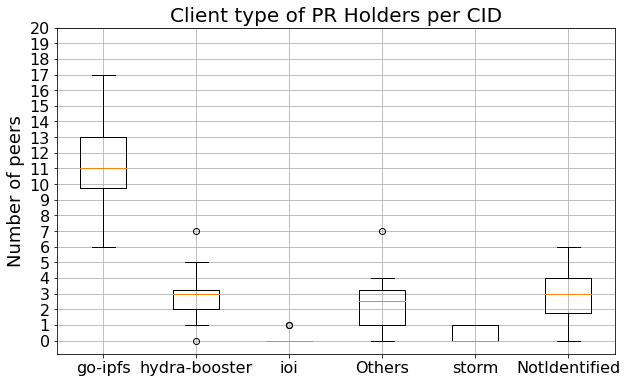

In [19]:
# plot the distribution of clients as PRs
fig, ax = plt.subplots(figsize=(10,6), facecolor="white")

ax.boxplot(cli_dist.values())
ax.set_xticks(np.arange(len(cli_dist))+1, cli_dist.keys())
ax.set_yticks(np.arange(20+1))
ax.set_title("Client distribution in PRs", fontsize=18)
ax.set_ylabel("Number of peers", fontsize=18)

plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

plt.title("Client type of PR Holders per CID", fontsize=20)
plt.grid()


In [20]:
pobj = pd.read_sql_query(
    """select i.user_agent, r.has_records, count(i.user_agent) 
    from ping_results as r
    left join peer_info as i on r.peer_id=i.peer_id 
    where r.ping_round=70 and r.has_records=true 
    group by i.user_agent, r.has_records
    ;""", db_con) 
print(pobj)

Empty DataFrame
Columns: [user_agent, has_records, count]
Index: []


In [21]:
db_con.close()